In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
input_features = ["Year", "State Name", "RICE AREA (1000 ha)", "JUN", "JUL", "AUG", "SEP"]
target = "RICE YIELD (Kg per ha)"
data = pd.read_csv("C:/Users/hiren/Downloads/Agriculture_RainData.csv")
data.loc[data[target]<0 , target] = 0
data_clean = data[input_features + [target]].dropna()
x = data_clean[input_features]
y = data_clean[target]
categorical_features = ["State Name"]
numeric_features = ["Year","RICE AREA (1000 ha)", "JUN", "JUL", "AUG", "SEP"]
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ("num", 'passthrough', numeric_features)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state = 42))
])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)
pipeline.fit(x_train, y_train)

y_pred = pipeline.predict(x_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score:", r2_score(y_test, y_pred))

user_state = "andhra pradesh"
user_year = 2020
user_area = 3500  
user_jun = 95.0   
user_jul = 180.0
user_aug = 170.0
user_sep = 140.0

user_input = pd.DataFrame({
    "Year": [user_year],
    "State Name": [user_state],
    "RICE AREA (1000 ha)": [user_area],
    "JUN": [user_jun],
    "JUL": [user_jul],
    "AUG": [user_aug],
    "SEP": [user_sep]
})

predicted_yield = pipeline.predict(user_input)[0]
print(f"✅ Predicted Rice Yield (Kg per ha) for {user_state.title()} in {user_year}: {predicted_yield:.2f}")


MAE: 152.6911337378316
RMSE: 234.58255780302966
R2 score: 0.9181412722026583
✅ Predicted Rice Yield (Kg per ha) for Andhra Pradesh in 2020: 2778.04


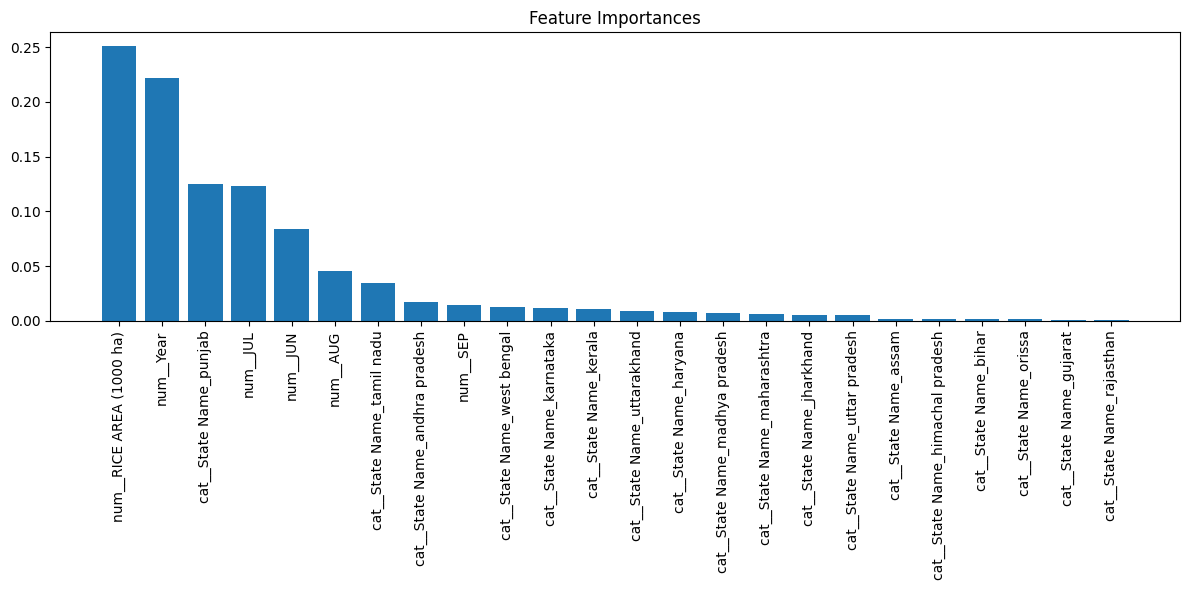

In [3]:
model = pipeline.named_steps["model"]
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

        High       0.98      0.90      0.94        58
         Low       0.91      0.89      0.90        66
      Medium       0.83      0.91      0.87        64

    accuracy                           0.90       188
   macro avg       0.91      0.90      0.90       188
weighted avg       0.90      0.90      0.90       188



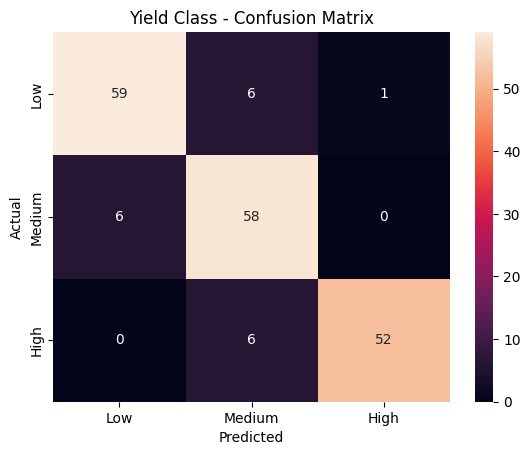

✅Predicted Yield Class: High


In [4]:
from sklearn.metrics import classification_report, confusion_matrix

data_clean["Yield_Class"] = pd.qcut(data_clean[target], q=3, labels=["Low", "Medium", "High"])

X_cls = data_clean[input_features]
y_cls = data_clean["Yield_Class"]

clf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
clf_pipeline.fit(X_train_cls, y_train_cls)

y_pred_cls = clf_pipeline.predict(X_test_cls)

print(classification_report(y_test_cls, y_pred_cls))

cm = confusion_matrix(y_test_cls, y_pred_cls, labels=["Low", "Medium", "High"])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Yield Class - Confusion Matrix")
plt.show()

yield_class = clf_pipeline.predict(user_input)[0]
print(f"✅Predicted Yield Class: {yield_class}")

***Rainfall Forecast***

            avg_rainfall
Year                    
2013-01-01    158.616667
2014-01-01    110.391667
2015-01-01    138.316667
2016-01-01    164.750000
2017-01-01    152.683333


C:\Users\hiren\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\hiren\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\hiren\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hiren\AppData\Local\Temp\ipykernel_83480\2140682158.py:26: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast.index = pd.date_range(start=df_avg.index[-1] + pd.DateOffset(years=1), periods=3, freq="Y")


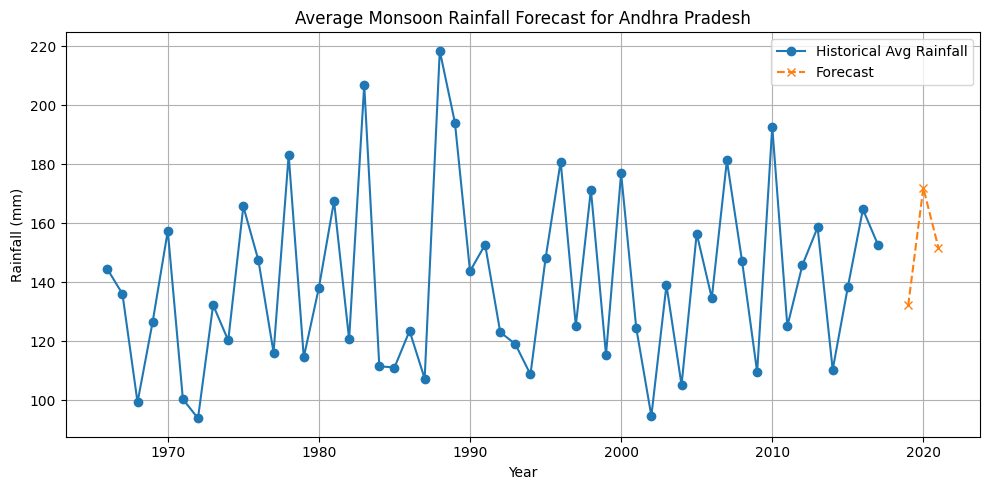

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

state = "andhra pradesh"

# Filter data for the selected state
df_state = data[data["State Name"].str.lower() == state.lower()]

rain_cols = ["JUN", "JUL", "AUG", "SEP"]
df_state = df_state[["Year"] + rain_cols].dropna()

df_state["avg_rainfall"] = df_state[rain_cols].mean(axis=1)

df_avg = df_state.groupby("Year")["avg_rainfall"].mean().reset_index()

# Convert year to datetime
df_avg["Year"] = pd.to_datetime(df_avg["Year"], format="%Y")
df_avg.set_index("Year", inplace=True)

print(df_avg.tail())

model = SARIMAX(df_avg["avg_rainfall"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast next 3 years
forecast = model_fit.forecast(steps=3)
forecast.index = pd.date_range(start=df_avg.index[-1] + pd.DateOffset(years=1), periods=3, freq="Y")

plt.figure(figsize=(10, 5))
plt.plot(df_avg.index, df_avg["avg_rainfall"], label="Historical Avg Rainfall", marker='o')
plt.plot(forecast.index, forecast, label="Forecast", linestyle='--', marker='x')
plt.title(f"Average Monsoon Rainfall Forecast for {state.title()}")
plt.ylabel("Rainfall (mm)")
plt.xlabel("Year")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



***Top performing states for rice***

C:\Users\hiren\AppData\Local\Temp\ipykernel_83480\601144219.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states_top10.values, y=top_states_top10.index, palette="Greens_r")


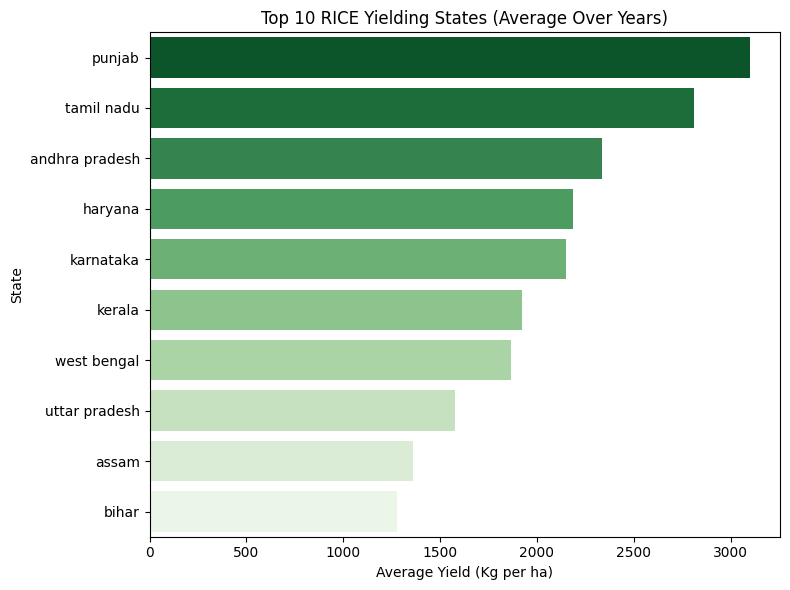

In [6]:
crop = "RICE"
yield_col = f"{crop} YIELD (Kg per ha)"

top_states = data_clean.groupby("State Name")[yield_col].mean().sort_values(ascending=False)

top_states_top10 = top_states.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_states_top10.values, y=top_states_top10.index, palette="Greens_r")
plt.xlabel("Average Yield (Kg per ha)")
plt.ylabel("State")
plt.title(f"Top 10 {crop} Yielding States (Average Over Years)")
plt.tight_layout()
plt.show()

***Correlation b/w Yield & Rainfall***

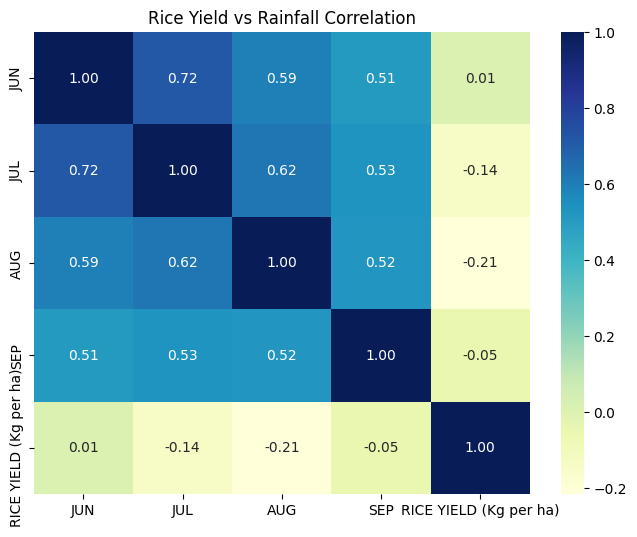

In [7]:
corr_data = data[rain_cols + [yield_col]].dropna()

# Compute correlation matrix
corr_matrix = corr_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title(f"{crop.title()} Yield vs Rainfall Correlation")
plt.show()

***Drought impact analysis***

🌾 Avg RICE Yield in Drought Years: 2064.60 kg/ha
🌿 Avg RICE Yield in Normal Years: 1458.89 kg/ha


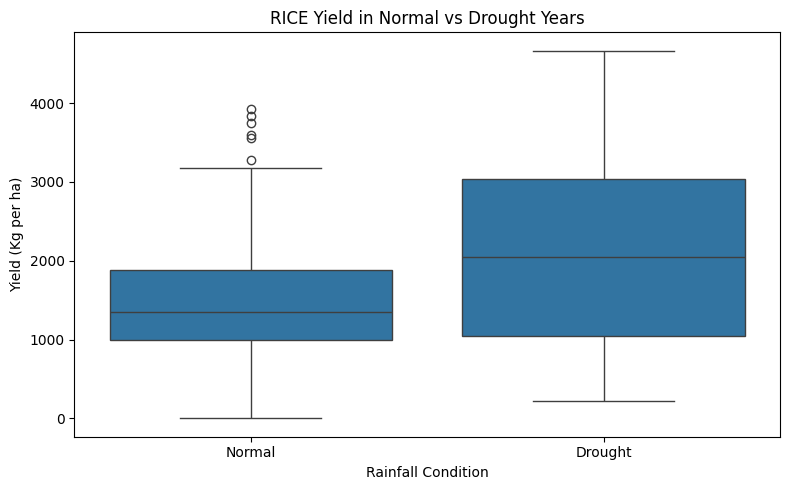

In [8]:
data_clean["Total_Rainfall"] = data_clean[rain_cols].sum(axis=1)

threshold = data_clean["Total_Rainfall"].quantile(0.25)
data_clean["Drought_Year"] = data_clean["Total_Rainfall"] < threshold

avg_yield_drought = data_clean[data_clean["Drought_Year"]][yield_col].mean()
avg_yield_normal = data_clean[~data_clean["Drought_Year"]][yield_col].mean()

print(f"🌾 Avg {crop} Yield in Drought Years: {avg_yield_drought:.2f} kg/ha")
print(f"🌿 Avg {crop} Yield in Normal Years: {avg_yield_normal:.2f} kg/ha")

plt.figure(figsize=(8, 5))
sns.boxplot(data=data_clean, x="Drought_Year", y=yield_col)
plt.xticks([0, 1], ["Normal", "Drought"])
plt.title(f"{crop} Yield in Normal vs Drought Years")
plt.ylabel("Yield (Kg per ha)")
plt.xlabel("Rainfall Condition")
plt.tight_layout()
plt.show()
